## 1.取得セクション

In [120]:
# APIの基本設定
API_TOKEN = "YOUR_API_TOKEN"  # 実際のAPIトークンに置き換えてください
API_TOKEN = "Hgt7Gj3Il3rQovE8OiU817jgmrKe9jnM"  # テスト後に削除
BASE_URL = "https://info.gbiz.go.jp/hojin"
HEADERS = {"X-hojinInfo-api-token": API_TOKEN}

# APIリクエストの間隔（秒）- レート制限対策
REQUEST_INTERVAL = 0.5

print("API設定が完了しました")
print(f"Base URL: {BASE_URL}")

API設定が完了しました
Base URL: https://info.gbiz.go.jp/hojin


##### データ取得テスト

In [122]:
from pprint import pprint
import requests

def get_subsidy_data_test():
    endpoint = f"{BASE_URL}/v1/hojin/updateInfo/subsidy"
    params = {
        'from': '20200401',
        'to': '20210331',
        'page': '1'
    }
    
    response = requests.get(endpoint, headers=HEADERS, params=params)
    return response.json()

test_data = get_subsidy_data_test() 
pprint(test_data)


{'errors': None,
 'hojin-infos': [{'corporate_number': '1000020470007',
                  'kana': 'おきなわけん',
                  'location': '沖縄県那覇市泉崎１丁目２－２',
                  'name': '沖縄県',
                  'name_en': 'Okinawa Prefectural Government',
                  'postal_code': '9000021',
                  'status': '-',
                  'subsidy': [{'amount': '6397000',
                               'date_of_approval': '2020-07-08',
                               'government_departments': '防衛省',
                               'joint_signatures': None,
                               'note': None,
                               'subsidy_resource': None,
                               'target': None,
                               'title': '美咲特別支援学校防音事業（実施設計）'},
                              {'amount': '2578000',
                               'date_of_approval': '2020-06-04',
                               'government_departments': '防衛省',
                               'joint_si

全件取得前にデータ件数の調査

In [123]:
def get_subsidy_data_count():
    endpoint = f"{BASE_URL}/v1/hojin/updateInfo/subsidy"
    params = {
        'from': '20200401',
        'to': '20210331'
    }
    response = requests.get(endpoint, headers=HEADERS, params=params)
    data = response.json()
    return data['totalCount']

subsidy_count = get_subsidy_data_count()
print(f"2020年度の補助金情報の総件数: {subsidy_count}件")

2020年度の補助金情報の総件数: 91892件


### データ取得

In [125]:
import sqlite3
import aiohttp
import asyncio
import time

def setup_database(db_connect):
    db_cursor = db_connect.cursor()
    
    # 補助金テーブル
    db_cursor.execute('''
    CREATE TABLE IF NOT EXISTS subsidies (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        corporate_number TEXT,
        company_name TEXT,
        subsidy_date TEXT,
        subsidy_title TEXT,
        amount TEXT
    )
    ''')
    
    # 処理済みページ記録テーブル
    db_cursor.execute('''
    CREATE TABLE IF NOT EXISTS processed_pages (
        data_type TEXT,
        page_number INTEGER,
        fiscal_year INTEGER,
        PRIMARY KEY (data_type, page_number, fiscal_year)
    )
    ''')
    
    db_connect.commit()
    return db_connect

def save_data_to_db(db_connect, data, fiscal_year):
    if not data or "hojin-infos" not in data:
        return 0, 0
    
    db_cursor = db_connect.cursor()
    companies_count = 0
    subsidies_count = 0
    
    for company in data["hojin-infos"]:
        companies_count += 1
        
        if "subsidy" in company and company["subsidy"]:
            for subsidy in company["subsidy"]:
                db_cursor.execute('''
                INSERT INTO subsidies 
                (corporate_number, company_name, subsidy_date, subsidy_title, amount)
                VALUES (?, ?, ?, ?, ?)
                ''', (
                    company.get("corporate_number", ""),
                    company.get("name", ""),
                    subsidy.get("date_of_approval", ""),
                    subsidy.get("title", ""),
                    subsidy.get("amount", "")
                ))
                subsidies_count += 1
    
    db_connect.commit()
    return companies_count, subsidies_count

async def fetch_subsidy_data(session, from_date=None, to_date=None, page=1):
    """非同期APIリクエスト - 補助金情報取得"""
    endpoint = f"{BASE_URL}/v1/hojin/updateInfo/subsidy"
    params = {
        'from': from_date,
        'to': to_date,
        'page': str(page)
    }
    
    try:
        async with session.get(endpoint, headers=HEADERS, params=params) as response:
            if response.status == 200:
                return await response.json()
            else:
                print(f"エラー: HTTPステータスコード {response.status}")
                return None
    except Exception as e:
        print(f"リクエストエラー: {e}")
        return None

def is_page_processed(db_connect, page, fiscal_year):
    """ページが処理済みかチェック"""
    db_cursor = db_connect.cursor()
    db_cursor.execute(
        'SELECT 1 FROM processed_pages WHERE data_type = ? AND page_number = ? AND fiscal_year = ?', 
        ('subsidy', page, fiscal_year)
    )
    return db_cursor.fetchone() is not None

def mark_page_processed(db_connect, page, fiscal_year):
    """ページを処理済みとしてマーク"""
    db_cursor = db_connect.cursor()
    db_cursor.execute(
        'INSERT OR IGNORE INTO processed_pages VALUES (?, ?, ?)', 
        ('subsidy', page, fiscal_year)
    )
    db_connect.commit()

async def get_subsidy_data_prod(from_date, to_date, fiscal_year, db_connect, batch_size=30):
    """非同期実行で全国の補助金情報を取得"""
    
    setup_database(db_connect)
    
    async with aiohttp.ClientSession() as session:
        # 最初に1ページ目を取得して総ページ数を確認
        initial_data = await fetch_subsidy_data(session, from_date, to_date, 1)
        if not initial_data or "totalPage" not in initial_data:
            print("総ページ数の取得に失敗しました")
            return
        
        total_pages = int(initial_data["totalPage"])
        print(f"補助金情報総ページ数: {total_pages}、期間: {from_date}～{to_date}、年度: {fiscal_year}")
        
        # 1ページ目の処理
        if not is_page_processed(db_connect, 1, fiscal_year):
            companies, subsidies = save_data_to_db(db_connect, initial_data, fiscal_year)
            mark_page_processed(db_connect, 1, fiscal_year)
            print(f"ページ 1: {companies}社の情報と{subsidies}件の補助金情報を保存")
        else:
            print("ページ 1は処理済みです")
        
        # 残りのページをbatch_sizeページずつバッチ処理
        total_companies = 0
        total_subsidies = 0
        processed_pages = 1
        start_time = time.time()
        
        for start_page in range(2, total_pages + 1, batch_size):
            batch_tasks = []
            batch_pages = []
            
            for page in range(start_page, min(start_page + batch_size, total_pages + 1)):
                if not is_page_processed(db_connect, page, fiscal_year):
                    batch_tasks.append(fetch_subsidy_data(session, from_date, to_date, page))
                    batch_pages.append(page)
                else:
                    print(f"ページ {page} は処理済みです")
            
            if batch_tasks:
                print(f"バッチ取得: {len(batch_tasks)} ページ")
                results = await asyncio.gather(*batch_tasks)
                
                for i, result in enumerate(results):
                    page = batch_pages[i]
                    if result:
                        companies, subsidies = save_data_to_db(db_connect, result, fiscal_year)
                        mark_page_processed(db_connect, page, fiscal_year)
                        total_companies += companies
                        total_subsidies += subsidies
                        processed_pages += 1
                        
                        # 進捗表示
                        elapsed_time = time.time() - start_time
                        avg_time_per_page = elapsed_time / processed_pages if processed_pages > 0 else 0
                        remaining_pages = total_pages - processed_pages
                        est_remaining_time = avg_time_per_page * remaining_pages
                        
                        print(f"ページ {page}/{total_pages}: {companies}社, {subsidies}件 " +
                              f"(進捗: {processed_pages/total_pages*100:.1f}%, 残り約{est_remaining_time/60:.1f}分)")
                
                await asyncio.sleep(1)  # APIレート制限対策
    
    # 最終結果の表示
    db_cursor = db_connect.cursor()
    
    # companies テーブルは使用していないので修正
    db_cursor.execute("SELECT COUNT(DISTINCT corporate_number) FROM subsidies")
    total_companies = db_cursor.fetchone()[0]
    
    db_cursor.execute("SELECT COUNT(*) FROM subsidies")
    total_subsidies = db_cursor.fetchone()[0]
    
    elapsed_time = time.time() - start_time
    print(f"\n処理完了 ({elapsed_time/60:.1f}分): {fiscal_year}年度データ")
    print(f"データベースには{total_companies}社の法人情報と{total_subsidies}件の補助金情報があります")


In [126]:
# 取得年度を2020年で定義（新型コロナの影響により最もデータが豊富に取れると考えた）
FISCAL_YEAR = 2020
from_date = f"{FISCAL_YEAR}0401"
to_date = f"{FISCAL_YEAR+1}0331"

# ダウンロード時sqlite3に保存
db_connect = sqlite3.connect('gbiz.sqlite3')

データを取得して外部保存
- 補助金の件数が、最初に調べた件数と同じになることを確かめてください
- 違っていれば、再実行してください

In [127]:

await get_subsidy_data_prod(
    from_date=from_date, 
    to_date=to_date, 
    fiscal_year=FISCAL_YEAR, 
    db_connect=db_connect,
    batch_size=40  # バッチサイズを指定
)
db_connect.close()

補助金情報総ページ数: 919、期間: 20200401～20210331、年度: 2020
ページ 1は処理済みです
ページ 2 は処理済みです
ページ 3 は処理済みです
ページ 4 は処理済みです
ページ 5 は処理済みです
ページ 6 は処理済みです
ページ 7 は処理済みです
ページ 8 は処理済みです
ページ 9 は処理済みです
ページ 10 は処理済みです
ページ 11 は処理済みです
ページ 12 は処理済みです
ページ 13 は処理済みです
ページ 14 は処理済みです
ページ 15 は処理済みです
ページ 16 は処理済みです
ページ 17 は処理済みです
ページ 18 は処理済みです
ページ 19 は処理済みです
ページ 20 は処理済みです
ページ 21 は処理済みです
ページ 22 は処理済みです
ページ 23 は処理済みです
ページ 24 は処理済みです
ページ 25 は処理済みです
ページ 26 は処理済みです
ページ 27 は処理済みです
ページ 28 は処理済みです
ページ 29 は処理済みです
ページ 30 は処理済みです
ページ 31 は処理済みです
ページ 32 は処理済みです
ページ 33 は処理済みです
ページ 34 は処理済みです
ページ 35 は処理済みです
ページ 36 は処理済みです
ページ 37 は処理済みです
ページ 38 は処理済みです
ページ 39 は処理済みです
ページ 40 は処理済みです
ページ 41 は処理済みです
ページ 42 は処理済みです
ページ 43 は処理済みです
ページ 44 は処理済みです
ページ 45 は処理済みです
ページ 46 は処理済みです
ページ 47 は処理済みです
ページ 48 は処理済みです
ページ 49 は処理済みです
ページ 50 は処理済みです
ページ 51 は処理済みです
ページ 52 は処理済みです
ページ 53 は処理済みです
ページ 54 は処理済みです
ページ 55 は処理済みです
ページ 56 は処理済みです
ページ 57 は処理済みです
ページ 58 は処理済みです
ページ 59 は処理済みです
ページ 60 は処理済みです
ページ 61 は処理済みです
ページ 62 は処理済みです
ページ 63 は処理済みです
ページ 64 は処理済みです
ページ

## 2.分析セクション


メモリ上にデータを取り込む

In [3]:
import sqlite3
import pandas as pd

db_connect = sqlite3.connect('gbiz.sqlite3')

subsidy_df = pd.read_sql_query("SELECT * FROM subsidies",db_connect)
company_df = pd.read_sql_query("SELECT * FROM companies", db_connect)


In [4]:
# 補助金交付データ状況チェック
subsidy_df.columns

Index(['id', 'corporate_number', 'title', 'amount', 'date_of_approval',
       'government_departments', 'subsidy_resource', 'target', 'note',
       'fiscal_year'],
      dtype='object')

In [22]:
# 補助金交付が企業に対して重複しているかをチェック
any(company_df.duplicated(subset=['corporate_number']))

True

In [27]:
duplicated_companies = company_df[company_df.duplicated(subset=['corporate_number'], keep=False)]
duplicated_companies.shape
duplicated_companies.sort_values(by=['corporate_number']).head(20)


,corporate_number,name,kana,name_en,location,postal_code,status,update_date,fiscal_year
112359,1000020012131,苫小牧市,とまこまいし,Tomakomai City,北海道苫小牧市旭町４丁目５－６,0530018,-,2018-04-02T00:00:00+09:00,2020
91055,1000020012131,苫小牧市,とまこまいし,Tomakomai City,北海道苫小牧市旭町４丁目５－６,0530018,-,2018-04-02T00:00:00+09:00,2023
91348,1000020012271,歌志内市,うたしないし,Utashinai City,北海道歌志内市字本町５,0730403,-,2020-08-11T00:00:00+09:00,2020
53080,1000020012271,歌志内市,うたしないし,Utashinai City,北海道歌志内市字本町５,0730403,-,2020-08-11T00:00:00+09:00,2023
3596,1000020013030,当別町,とうべつちょう,Tobetsu,北海道石狩郡当別町白樺町５８－９,0610233,-,2018-04-02T00:00:00+09:00,2023
95401,1000020013030,当別町,とうべつちょう,Tobetsu,北海道石狩郡当別町白樺町５８－９,0610233,-,2018-04-02T00:00:00+09:00,2020
53343,1000020013625,上ノ国町,かみのくにちょう,Kaminokuni Town,北海道檜山郡上ノ国町字大留１００,0490611,-,2018-04-16T00:00:00+09:00,2023
113247,1000020013625,上ノ国町,かみのくにちょう,Kaminokuni Town,北海道檜山郡上ノ国町字大留１００,0490611,-,2018-04-16T00:00:00+09:00,2020
95402,1000020013633,厚沢部町,あっさぶちょう,Assabu Town,北海道檜山郡厚沢部町新町２０７,0431113,-,2018-04-02T00:00:00+09:00,2020
3597,1000020013633,厚沢部町,あっさぶちょう,Assabu Town,北海道檜山郡厚沢部町新町２０７,0431113,-,2018-04-02T00:00:00+09:00,2023


In [21]:

# 補助金交付が企業に対して重複しているかを一応チェック
any(subsidy_df.duplicated(subset=['corporate_number']))

True

補助金データに関して、企業IDで集約

In [6]:
company_counts_df = subsidy_df.groupby('corporate_number').agg({
    'id': 'count',  # 補助金の数をカウント
}).reset_index().rename(columns={'id': 'subsidy_count'})

In [82]:
company_counts_df.columns

Index(['corporate_number', 'subsidy_count'], dtype='object')

In [83]:
company_counts_df.shape

(97550, 2)

In [110]:
# 降順でソート
company_counts_df = company_counts_df.sort_values('subsidy_count', ascending=False)
company_counts_df.head()

,corporate_number,subsidy_count
76314,8000020460001,1047
11264,2000020350001,921
65254,7000020010006,908
65287,7000020070009,882
43751,5000020150002,868


企業の補助金受け取り回数でソートして、グラフで可視化

In [7]:
company_counts_df.head(800).to_csv('company_counts.csv', index=False)

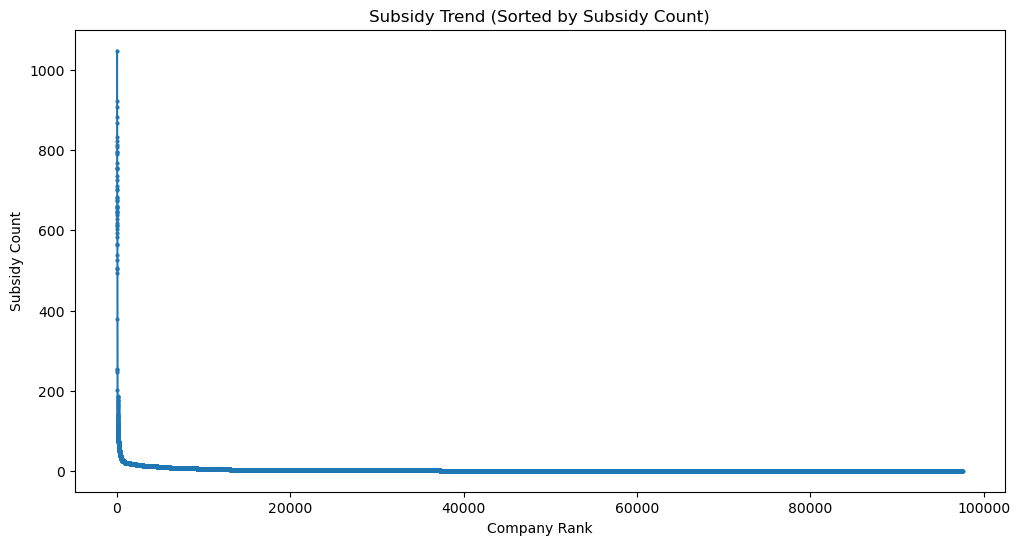

In [111]:
import matplotlib.pyplot as plt


def subsidy_trend_analysis(df, variable):
    sorted_df = df.sort_values(variable, ascending=False)
    
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(sorted_df)), sorted_df[variable], 'o-', markersize=2)
    plt.title('Subsidy Trend (Sorted by Subsidy Count)')
    plt.xlabel('Company Rank')
    plt.ylabel('Subsidy Count')
    plt.show()

subsidy_trend_analysis(df=company_counts_df, variable='subsidy_count')




以上の可視化情報から、以降補助金の受け取り頻度はロングテール（Long Tail） 分布に従うという仮説のもと詳細調査をしていく。

つまり、
- ヘッド：左側（急激に高い値の部分）の超高頻度受給の企業クラスタ
- ロングテイル：右側（長く伸びる低い値の部分）の一般層のクラスタ



In [8]:
def cluster_subsidies_by_rank(df, top_n=500):
    """
    企業の補助金受給数を順位で分類し、上位N社を高頻度グループとする
    
    引数:
    df: 'corporate_number'と'subsidy_count'カラムを持つDataFrame
    top_n: 高頻度グループとする上位企業数 (デフォルト: 500)
    
    戻り値:
    tuple: (high_frequency_group_df, low_frequency_group_df)
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    
    # 元のデータフレームを変更しないようにコピー
    df_copy = df.copy()
    
    # 補助金数で降順ソート
    df_sorted = df_copy.sort_values('subsidy_count', ascending=False).reset_index(drop=True)
    
    # 上位N社を高頻度グループとして抽出
    high_frequency_group_df = df_sorted.iloc[:top_n]
    low_frequency_group_df = df_sorted.iloc[top_n:]
    
    # 閾値（N+1位の補助金数）
    threshold = low_frequency_group_df['subsidy_count'].iloc[0] if len(low_frequency_group_df) > 0 else 0
    
    # 分類結果を表示
    print(f"上位{top_n}社を高頻度グループに分類")
    print(f"閾値: {threshold}回以上の補助金受給")
    print(f"高頻度グループ: {len(high_frequency_group_df)}社")
    print(f"平均補助金数: {high_frequency_group_df['subsidy_count'].mean():.2f}")
    print(f"最大補助金数: {high_frequency_group_df['subsidy_count'].max()}")
    print(f"最小補助金数: {high_frequency_group_df['subsidy_count'].min()}")
    print(f"\n低頻度グループ: {len(low_frequency_group_df)}社")
    print(f"平均補助金数: {low_frequency_group_df['subsidy_count'].mean():.2f}")
    print(f"最大補助金数: {low_frequency_group_df['subsidy_count'].max()}")
    print(f"最小補助金数: {low_frequency_group_df['subsidy_count'].min()}")
    
    # クラスタリング結果を可視化
    plt.figure(figsize=(12, 8))
    
    # 高頻度グループをプロット（赤）
    plt.scatter(range(len(high_frequency_group_df)), 
                high_frequency_group_df['subsidy_count'],
                c='red',
                label=f'High Frequency Group (Top {top_n} companies)')
    
    # 低頻度グループをプロット（青）
    plt.scatter(range(len(high_frequency_group_df), len(df_sorted)), 
                low_frequency_group_df['subsidy_count'],
                c='blue',
                label=f'Low Frequency Group ({len(low_frequency_group_df)} companies)')
    
    # 閾値ラインを追加（黄色）
    plt.axhline(y=threshold, color='yellow', linestyle='-', linewidth=2,
                label=f'Threshold: {threshold} subsidies')
    
    plt.xlabel('Company Rank')
    plt.ylabel('Subsidy Count')
    plt.title(f'Distribution of Subsidies Among Companies (Top {top_n} Highlighted)')
    plt.legend()
    
    return high_frequency_group_df, low_frequency_group_df

上位492社を高頻度グループに分類
閾値: 31回以上の補助金受給
高頻度グループ: 492社
平均補助金数: 125.47
最大補助金数: 1047
最小補助金数: 31

低頻度グループ: 97058社
平均補助金数: 2.58
最大補助金数: 31
最小補助金数: 1


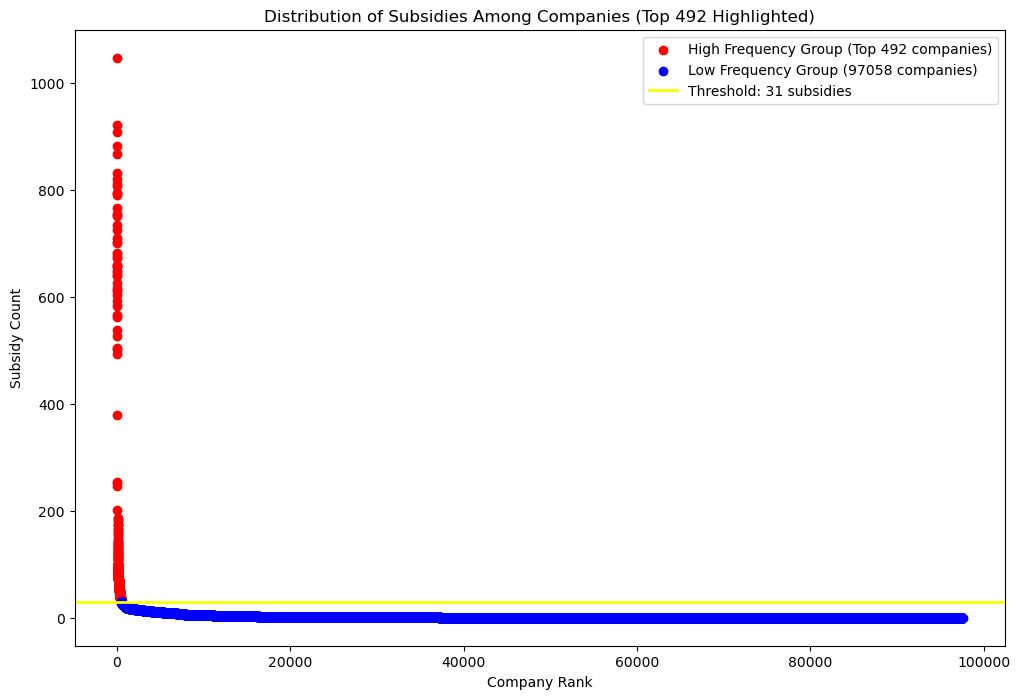

In [11]:
high_frequency_group_df, low_frequency_group_df = cluster_subsidies_by_rank(df=company_counts_df,top_n=492)

### ヘッド解析

In [14]:
high_frequency_group_df.shape

(492, 2)

In [15]:
high_frequency_group_df.columns

Index(['corporate_number', 'subsidy_count'], dtype='object')

In [16]:
company_df.columns

Index(['corporate_number', 'name', 'kana', 'name_en', 'location',
       'postal_code', 'status', 'update_date', 'fiscal_year'],
      dtype='object')

In [20]:
head_df = pd.merge(high_frequency_group_df, company_df, on='corporate_number', how='left')
# 重複を排除してマージ
# head_df = pd.merge(high_frequency_group_df, company_df, on='corporate_number', how='left').drop_duplicates(subset='corporate_number')
head_df.shape

(492, 10)

In [61]:
print(high_frequency_group_df['corporate_number'].is_unique)  # Trueであるべき
# print(high_frequency_group_df['corporate_number'].nunique())
# print(high_frequency_group_df.shape)

KeyError: 'corporate_number'

In [62]:
print(high_frequency_group_df.columns)

Index(['subsidy_count', 'total_amount', 'government_departments'], dtype='object')


In [63]:
high_df = pd.merge(high_frequency_group_df.reset_index(), company_df, on='corporate_number', how='left')

In [65]:
company_counts_df.columns

Index(['subsidy_count', 'total_amount', 'government_departments'], dtype='object')

### ロングテイル解析

In [ ]:
df_outer = pd.merge(high_frequency_group_df, company_df, on='corporate_number', how='left')
df_outer

In [ ]:
low_frequency_group_df.shape[0]

In [46]:
df_outer = pd.merge(low_frequency_group_df, company_df, on='corporate_number', how='left')


In [ ]:
df_outer.head()

In [ ]:
df_outer[["name","subsidy_count","total_amount"]].head(5)

高頻度グループ: 48社, 平均補助金数: 689.98
低頻度グループ: 97502社, 平均補助金数: 2.86


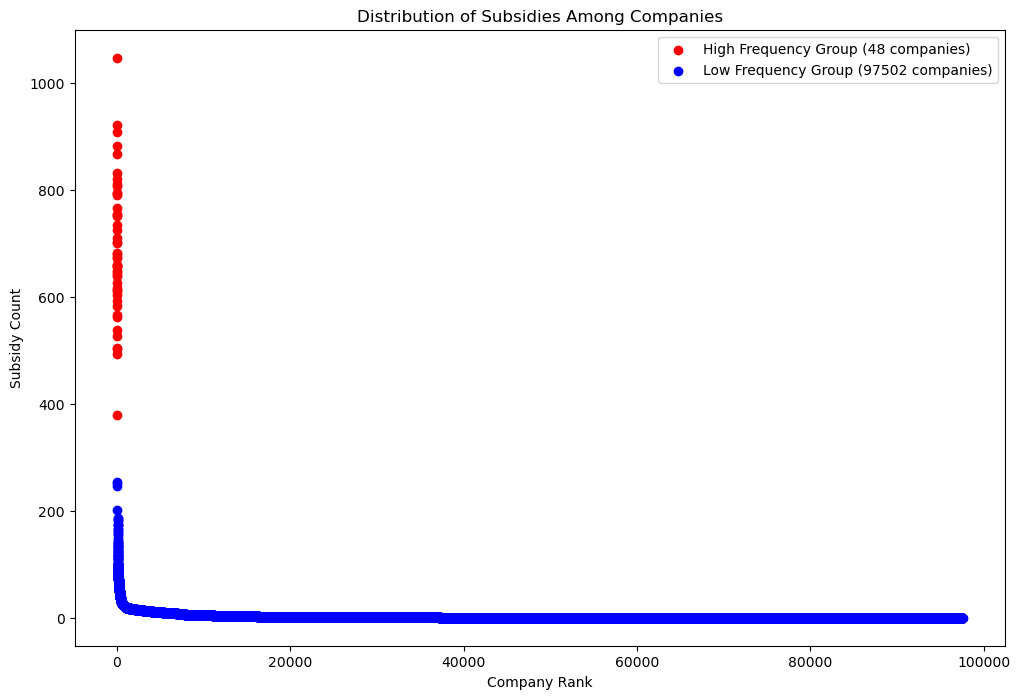

In [188]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# データ読み込み（実際の環境では既にDataFrameが読み込まれている）
# company_counts_df = pd.read_csv('company_counts-1.csv')

# K-meansでクラスタリング（2グループ）
X = company_counts_df['subsidy_count'].values.reshape(-1, 1)
kmeans = KMeans(n_clusters=2, random_state=42)
company_counts_df['cluster'] = kmeans.fit_predict(X)

# クラスタ中心点を取得
centers = kmeans.cluster_centers_
# 高頻度グループと低頻度グループを特定（クラスタ中心値の大きさで判断）
high_cluster = np.argmax([c[0] for c in centers])
low_cluster = np.argmin([c[0] for c in centers])

# 高頻度グループと低頻度グループに分割
high_frequency_group_df = company_counts_df[company_counts_df['cluster'] == high_cluster]
low_frequency_group_df = company_counts_df[company_counts_df['cluster'] == low_cluster]

# 結果確認
print(f"高頻度グループ: {len(high_frequency_group_df)}社, 平均補助金数: {high_frequency_group_df['subsidy_count'].mean():.2f}")
print(f"低頻度グループ: {len(low_frequency_group_df)}社, 平均補助金数: {low_frequency_group_df['subsidy_count'].mean():.2f}")

# グループの特徴を視覚化
plt.figure(figsize=(12, 8))

plt.scatter(range(len(high_frequency_group_df)), 
            high_frequency_group_df['subsidy_count'], 
            c='red', 
            label=f'High Frequency Group ({len(high_frequency_group_df)} companies)')

plt.scatter(range(len(high_frequency_group_df), len(company_counts_df)), 
            low_frequency_group_df['subsidy_count'], 
            c='blue', 
            label=f'Low Frequency Group ({len(low_frequency_group_df)} companies)')

plt.xlabel('Company Rank')
plt.ylabel('Subsidy Count')
plt.title('Distribution of Subsidies Among Companies')
plt.legend()

plt.show()

